### Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import DenseNet121
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras_applications.vgg16 import VGG16,preprocess_input
from keras_applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from keras.utils import image_dataset_from_directory

print("All Libraries are ready to used in the project")



All Libraries are ready to used in the project


In [22]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = 'Dataset'

# Set the base directory for the split images
output_folder = 'Neetpal/Splitted'

# Set the ratio of images for each split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 0 files [00:00, ? files/s]

Copying files: 6400 files [01:26, 74.10 files/s] 


In [23]:
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = 'Neetpal/Splitted/train'
validation_dir = 'Neetpal/Splitted/val'
test_dir = 'Neetpal/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 3839 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 1282 images belonging to 4 classes.


In [24]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

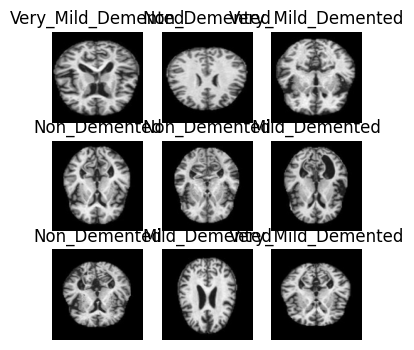

In [25]:
plt.figure(figsize=(4, 4))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [26]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation
    # print(data_augmentation)

In [27]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [28]:
## Calculate number of samples in each class.
input_folder = 'Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

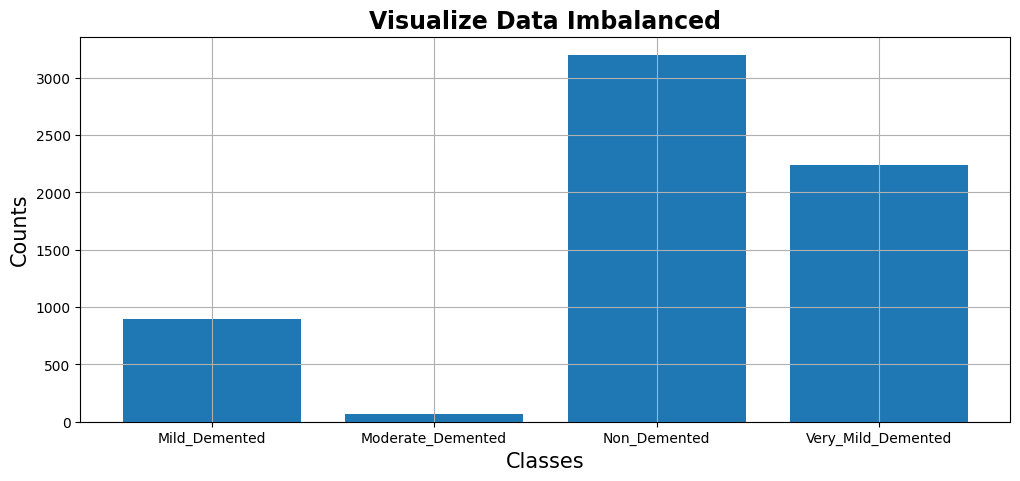

In [29]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [30]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [31]:
models=[]
acc=[]

### **VGG19**

In [32]:
# from keras_applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.applications import VGG19


base_model_3 = VGG19(
    input_shape=(128, 128, 3),  # Ensure input has 3 channels (RGB)
    include_top=False,
    weights="imagenet"
)

for layer in base_model_3.layers:
    layer.trainable = False



In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model3 = tf.keras.Sequential([base_model_3, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [34]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 436s 7s/step - accuracy: 0.5118 - auc: 0.8046 - loss: 1.0154 - precision: 0.5841 - recall: 0.3554 - val_accuracy: 0.4410 - val_auc: 0.7913 - val_loss: 1.0679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 481s 8s/step - accuracy: 0.6067 - auc: 0.8669 - loss: 0.8340 - precision: 0.6881 - recall: 0.4490 - val_accuracy: 0.5747 - val_auc: 0.8431 - val_loss: 1.0264 - val_precision: 0.8551 - val_recall: 0.0461
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 522s 9s/step - accuracy: 0.6386 - auc: 0.8877 - loss: 0.7766 - precision: 0.7130 - recall: 0.5436 - val_accuracy: 0.6357 - val_auc: 0.8678 - val_loss: 0.9564 - val_precision: 0.9027 - val_recall: 0.2103
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 521s 9s/step - accuracy: 0.6779 - auc: 0.8992 - loss: 0.7428 - precision: 0.7391 - recall: 0.5737 - val_accuracy: 0.6552 - val_auc: 0.8943 - val_loss: 0.8511 - val_precision: 0.8390 - val_recall: 0.3464
Epoch 5/10
60/60 ━━━━━━━━━━━

In [36]:
models.append("VGG 19")
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,771,726 (102.13 MB)

 Trainable params: 2,248,772 (8.58 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

 Optimizer params: 4,497,546 (17.16 MB)

In [37]:
result = model3.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

train_generator

60/60 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step - accuracy: 0.8429 - auc: 0.9733 - loss: 0.4014 - precision: 0.8696 - recall: 0.8035
Train Loss = 0.4039517343044281
Train Accuracy = 0.841625452041626
Train AUC = 0.9731643795967102
Train Precision = 0.8704384565353394
Train Recall = 0.8015108108520508


In [38]:
filepath = './Vgg_best_weights.keras'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [40]:
history3=model3.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 10,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9688 - auc: 0.9865 - loss: 0.2859 - precision: 0.9683 - recall: 0.9531
Epoch 1: val_accuracy improved from -inf to 0.79750, saving model to ./Vgg_best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 124s 124s/step - accuracy: 0.9688 - auc: 0.9865 - loss: 0.2859 - precision: 0.9683 - recall: 0.9531 - val_accuracy: 0.7975 - val_auc: 0.9568 - val_loss: 0.4874 - val_precision: 0.8203 - val_recall: 0.7639
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8594 - auc: 0.9729 - loss: 0.4094 - precision: 0.8793 - recall: 0.7969
Epoch 2: val_accuracy improved from 0.79750 to 0.80219, saving model to ./Vgg_best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - accuracy: 0.8594 - auc: 0.9729 - loss: 0.4094 - precision: 0.8793 - recall: 0.7969 - val_accuracy: 0.8022 - val_auc: 0.9595 - val_loss: 0.4745 - val_precision: 0.8253 - val_recall: 0.7756
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7812 - auc: 0.9606 - los

In [42]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



21/21 ━━━━━━━━━━━━━━━━━━━━ 121s 6s/step - accuracy: 0.7514 - auc: 0.9400 - loss: 0.5909 - precision: 0.7680 - recall: 0.7242
Test Loss = 0.5873304009437561
Test Accuracy = 0.7566302418708801
Test AUC = 0.9419372081756592
Test Precision = 0.7728394865989685
Test Recall = 0.7324492931365967


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
85.19 % chances are there that the image is Non_Demented


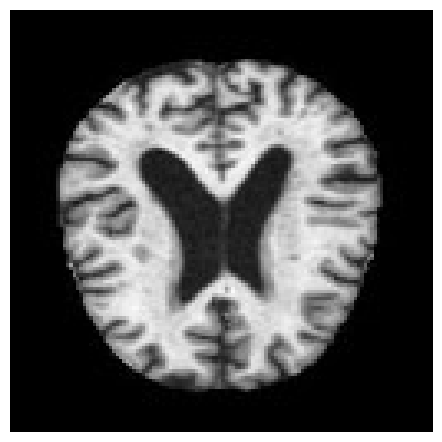

In [ ]:
# dic = test_generator.class_indices
# idc = {k:v for v, k in dic.items()}

# img = load_img('Neetpal/Splitted/test/Mild_Demented/mild_8.jpg', target_size = (128,128,3))
# img = img_to_array(img)
# img = img/255
# imshow(img)
# plt.axis('off')
# img = np.expand_dims(img,axis=0)
# answer = np.argmax(model3.predict(img),axis=1)
# y_pred_prob = model3.predict(img)
# y_pred = np.round(np.max(y_pred_prob)*100,2)

# print(y_pred, '% chances are there that the image is',idc[answer[0]])

### VGG 19 Model Prediction

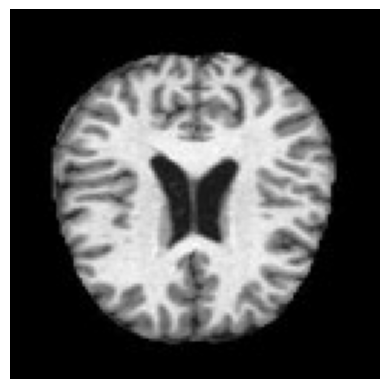

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
96.31% chances are there that the image is Non_Demented.


In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
my_model = load_model('Vgg_best_weights.keras')

# Mapping classes
dic = test_generator.class_indices  # Ensure test_generator is defined properly
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img('Neetpal/Splitted/test/Non_Demented/non_5.jpg', target_size=(128, 128, 3))
img = img_to_array(img) / 255.0  # Normalize the image
plt.imshow(img)  
plt.axis('off')
plt.show()
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make predictions
predictions = my_model.predict(img)
predicted_class = idc[np.argmax(predictions)]  # Get the class name
confidence = np.max(predictions) * 100

print(f"{confidence:.2f}% chances are there that the image is {predicted_class}.")




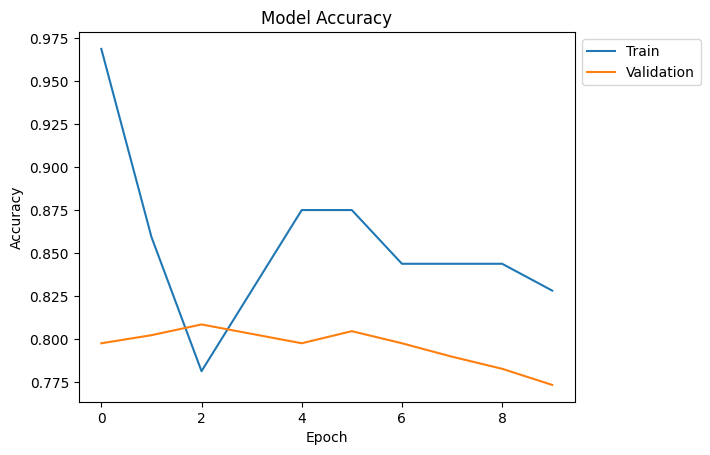

In [54]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [56]:
plt.plot(history3.history['auc_1'])
plt.plot(history3.history['val_auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

KeyError: 'auc_1'

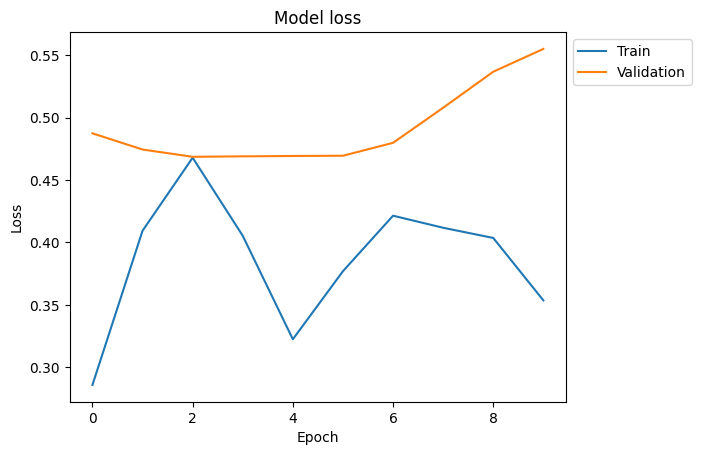

In [57]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [58]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [59]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step


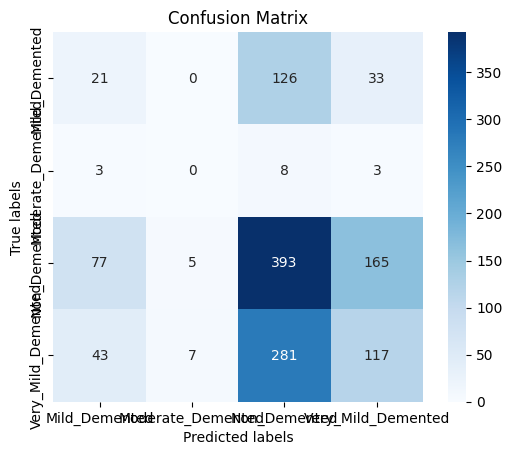

In [61]:
#Confusion Matrix for vgg19

p = model3.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab = test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)


## DenseNet121

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import DenseNet121
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras_applications.vgg16 import VGG16,preprocess_input
from keras_applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from keras.utils import image_dataset_from_directory

print("All Libraries are ready to used in the project")

All Libraries are ready to used in the project


In [3]:
base_model_4 = DenseNet121(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")

In [4]:
for layer in base_model_4.layers:
    layer.trainable=False

In [16]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))

model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │    33,556,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,296,836 (165.16 MB)

 Trainable params: 36,220,420 (138.17 MB)

 Non-trainable params: 7,076,416 (26.99 MB)

In [17]:
# models.append(model)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │    33,556,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,296,836 (165.16 MB)

 Trainable params: 36,220,420 (138.17 MB)

 Non-trainable params: 7,076,416 (26.99 MB)

In [18]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


NameError: name 'train_generator' is not defined

In [ ]:
models.append("DenseNet121")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 2048)              33556480  
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [ ]:
result = model.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

60/60 [==============================] - 18s 296ms/step - loss: 0.4794 - accuracy: 0.8221 - auc: 0.9653 - precision: 0.8644 - recall: 0.7570
Train Loss = 0.4794031083583832
Train Accuracy = 0.8220890760421753
Train AUC = 0.9653370976448059
Train Precision = 0.8643664717674255
Train Recall = 0.7569679617881775


In [ ]:
filepath = './DenseNet121_best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history4 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7812 - auc: 0.9490 - precision: 0.8421 - recall: 0.7500
Epoch 1: val_accuracy improved from -inf to 0.73964, saving model to ./DenseNet121_best_weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.5385 - accuracy: 0.7812 - auc: 0.9490 - precision: 0.8421 - recall: 0.7500 - val_loss: 0.5772 - val_accuracy: 0.7396 - val_auc: 0.9380 - val_precision: 0.7747 - val_recall: 0.6990
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.7031 - auc: 0.9227 - precision: 0.7736 - recall: 0.6406
Epoch 2: val_accuracy did not improve from 0.73964
1/1 [==============================] - 2s 2s/step - loss: 0.6334 - accuracy: 0.7031 - auc: 0.9227 - precision: 0.7736 - recall: 0.6406 - val_loss: 0.5747 - val_accuracy: 0.7342 - val_auc: 0.9386 - val_precision: 0.7735 - val_recall: 0.6943
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.7640 - accurac

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

21/21 [==============================] - 2s 94ms/step - loss: 0.4888 - accuracy: 0.7988 - auc: 0.9576 - precision: 0.8218 - recall: 0.7808
Test Loss = 0.4888087511062622
Test Accuracy = 0.798751950263977
Test AUC = 0.9576445817947388
Test Precision = 0.8218390941619873
Test Recall = 0.7808112502098083


1/1 [==============================] - 0s 35ms/step
93.01 % chances are there that the image is Mild_Demented


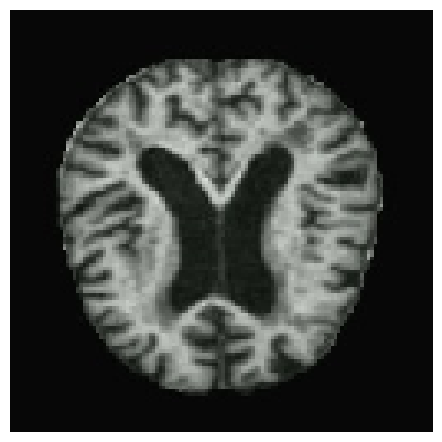

In [ ]:
dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img),axis=1)
y_pred_prob = model.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% Chances are there that the image is',idc[answer[0]])

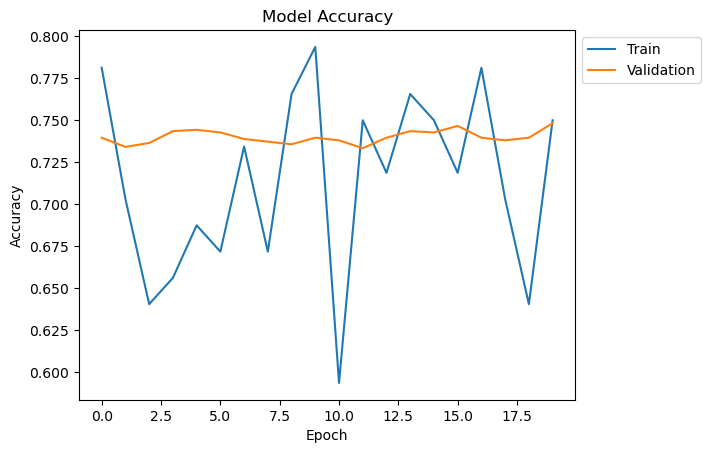

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

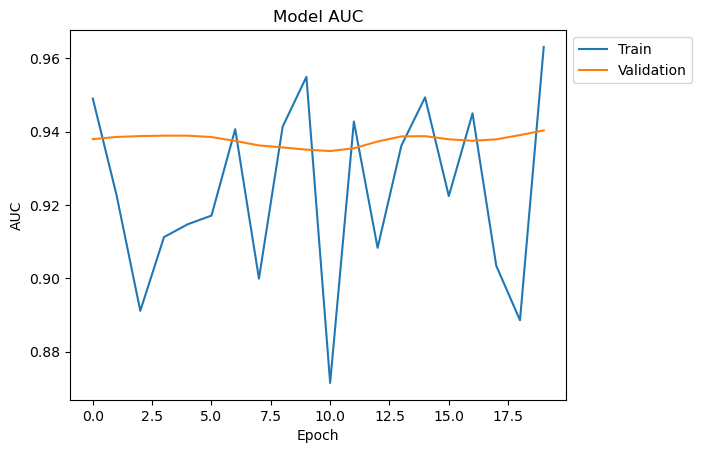

In [ ]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

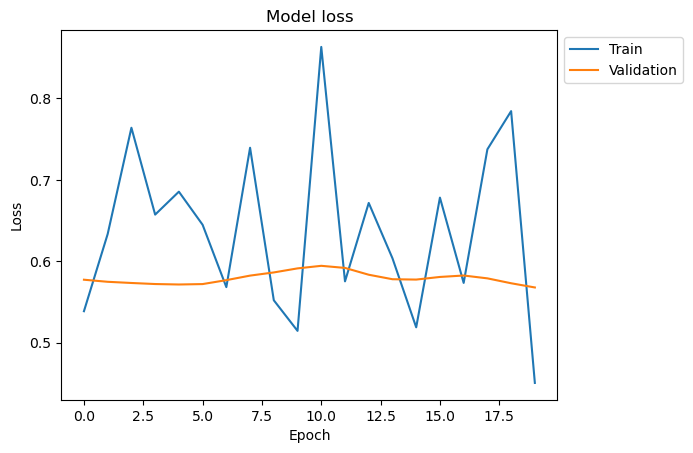

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 [==============================] - 3s 71ms/step


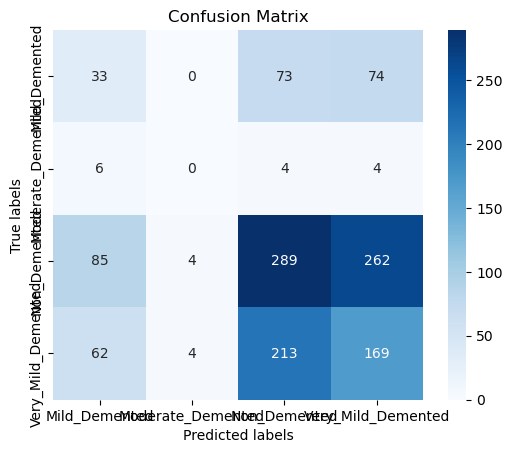

In [ ]:
#Confusion Matrix for densenet121 

p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab =test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)
